In [1]:
#построить модель регрессии, дерево решений, оптимизировать параметры и сравнить результаты#@

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pprint import pprint

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.datasets import load_boston

In [3]:
#boston = load_boston(return_X_y=False)
boston = pd.read_csv(load_boston()['filename'], skiprows=1)
X = boston.drop(['MEDV'], axis = 1); Y = boston['MEDV']; X.info(); X.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(10), int64(3)
memory usage: 51.5 KB


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


In [4]:
#выбор метрик для оценки
#R^2, коэффициент детерминации - сравним нашу модель с простейшей моделью (предсказание средней величины 
#целевой переменной)
#MSE, средняя квадратическая ошибка (берем корень из нее, чтобы была поменьше :)))
#MAE, средняя абсолютная ошибка - если есть выбросы, то она сгладит недостатки MSE

#функция подсчета ошибок
def model_metrics(y_true, y_pred, text = None):
    mse = round(mean_squared_error(y_true, y_pred, squared = False), 4)
    mae = round(mean_absolute_error(y_true, y_pred), 4)
    r2 = round(r2_score(y_true, y_pred), 4)
    if text != None:
        print(f'{text}:  MSE {mse},  MAE {mae},  R^2 {r2}')
    else:
        print(f'MSE {mse},  MAE {mae},  R^2 {r2}')
    return mse, mae, r2, text

#такой себе pipeline
def evaluating_the_model(metrics, X, Y, scal = False, text = None, params = None):
    #разбиваем данные на тренировочный и тестовый сэмплы
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)
    #проводим нормализацию по требованию
    if scal == True:
        X_tr = StandardScaler().fit_transform(X_train)
        X_t = StandardScaler().fit_transform(X_test)
    else:
        X_tr = X_train
        X_t = X_test
    #создам экземпляр класса LinearRegression, тренируем модель и получаем предсказание
    dt = DecisionTreeRegressor()
    if params == None:
        predictions = dt.fit(X_tr, y_train).predict(X_t)
        best_params = 'default parameters' #dt.get_params()
        feature_imp = dt.feature_importances_
    else:
        gsCV = GridSearchCV(dt, params)
        gsCV.fit(X_tr, y_train)
        best_params = gsCV.best_params_
        predictions = gsCV.predict(X_t)
        feature_imp = gsCV.best_estimator_.feature_importances_
    #считаем и фиксируем метрики
    mse, mae, r2, text = model_metrics(y_test, predictions, text)
    if params == None:
        metrics[text] = {'MSE':mse, 'MAE':mae, 'R^2':r2, 'imp':feature_imp, 'best':best_params}
    else:
        metrics[text] = {'MSE':mse, 'MAE':mae, 'R^2':r2, 'imp':feature_imp, 'best':best_params, \
                        'test_score':gsCV.cv_results_['mean_test_score']}
    
    #рисуем важность переменных
    importance_barchart(feature_imp, X)

    pass
 
#рисовать важность переменных
def importance_barchart(imp, X):
    plt.barh(np.arange(len(imp)), imp)
    plt.yticks(np.arange(len(X.columns)),X.columns)
    plt.show()
    
#рисовать результат предсказания и исходные данные
def print_the_results(f_test, t_test, t_pred, text, best_name):
    plt.figure()
    plt.scatter(f_test, t_pred, s=20, edgecolor="black", c="darkorange", label = 'predict')
    plt.scatter(f_test, t_test, s=20, edgecolor="black", c="blue", label = 'test')
    #plt.plot(f_test, t_test, color="cornflowerblue", linewidth=2)
    plt.xlabel(best_name)
    plt.ylabel("target")
    plt.title(text)
    plt.legend()
    plt.show()

-------------------------------------------------------------------------------------------------------------------

Размерность массивов: ((506, 13), (506,))
В1 - "в лоб":  MSE 3.5391,  MAE 2.6971,  R^2 0.8292


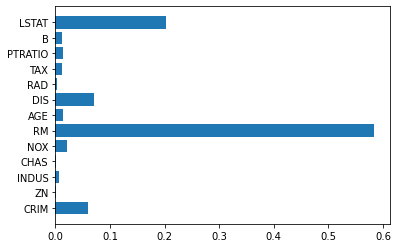

In [5]:
#В1 - "в лоб"
metrics = {}
#уточняю параметры массивов, на всякий случай
print(f'Размерность массивов: {X.shape, Y.shape}')
#тестирую модель
evaluating_the_model(metrics, X, Y, scal = False, text = 'В1 - "в лоб"')

Размерность массивов: ((506, 14), (506,))
В2 - LUX:  MSE 3.2948,  MAE 2.3882,  R^2 0.852


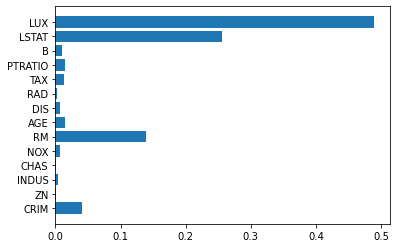

In [6]:
#В2 - LUX
#добавляю категориальные переменные для отделения сегмента LUX (по опыту ДЗ№7)
X['LUX'] = [0 if x < 38 else 1 for x in boston['MEDV']]
#уточняю параметры массивов, на всякий случай
print(f'Размерность массивов: {X.shape, Y.shape}')
#тестирую модель
evaluating_the_model(metrics, X, Y, scal = False, text = 'В2 - LUX')

In [7]:
#pprint(metrics)

In [8]:
#дерево решений каждый раз выдает похожий, но разный результат в обоих вариантах, причем, коэфф.детерминации
#непредсказуемо бывает больше и в В1 и в В2, что сводит на нет усилия по генерированию новой переменной X['LUX']

-------------------------------------------------------------------------------------------------------------------

In [9]:
#исследование параметров модели

В3 - max_depth:  MSE 2.908,  MAE 2.2237,  R^2 0.8847


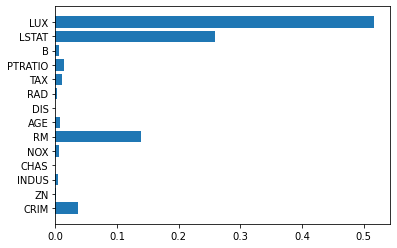

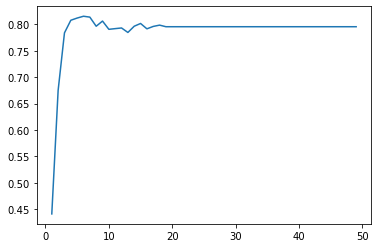

In [10]:
#В3 - max_depth
metrics_cv = {}
params = {'max_depth':np.arange(1, 50, 1),
          'random_state':[42]}
#тестирую модель
evaluating_the_model(metrics_cv, X, Y, scal = False, text = 'В3 - max_depth', params = params)
#нарисуем зависимость точности модели от max_depth
plt.plot(params['max_depth'], metrics_cv['В3 - max_depth']['test_score'])

In [11]:
#pprint(metrics_cv['В3 - max_depth'])

В4 - min_samples_leaf:  MSE 3.6405,  MAE 2.6059,  R^2 0.8193


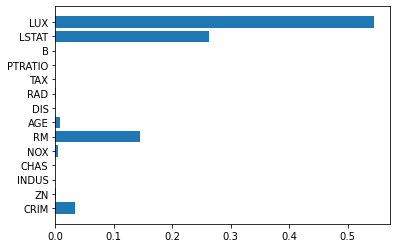

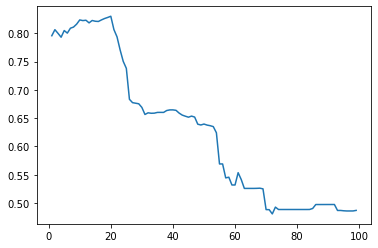

In [12]:
#В4 - min_samples_leaf
params = {'min_samples_leaf':np.arange(1, 100, 1),
          'random_state':[42]}
#тестирую модель
evaluating_the_model(metrics_cv, X, Y, scal = False, text = 'В4 - min_samples_leaf', params = params)
#нарисуем зависимость точности модели от min_samples_leaf
plt.plot(params['min_samples_leaf'], metrics_cv['В4 - min_samples_leaf']['test_score'])

In [13]:
#pprint(metrics_cv['В4 - min_samples_leaf'])

В5 - max_features:  MSE 3.366,  MAE 2.5735,  R^2 0.8455


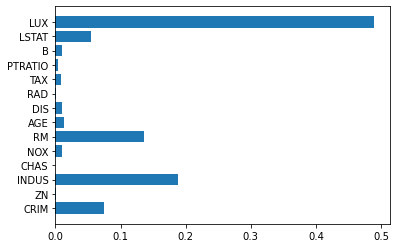

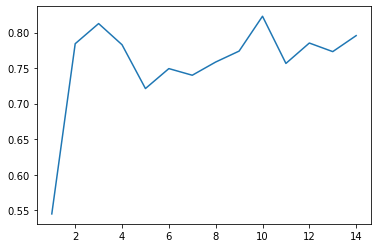

In [14]:
#В5 - max_features,
#params = {'max_features':['auto', 'sqrt', 'log2']}
params = {'max_features':np.arange(1, len(X.columns) + 1, 1),
          'random_state':[42]}
#тестирую модель
evaluating_the_model(metrics_cv, X, Y, scal = False, text = 'В5 - max_features', params = params)
#нарисуем зависимость точности модели от max_features
plt.plot(params['max_features'], metrics_cv['В5 - max_features']['test_score'])

In [15]:
#pprint(metrics_cv['В5 - max_features'])

В6 - ccp_alpha:  MSE 3.761,  MAE 2.9891,  R^2 0.8071


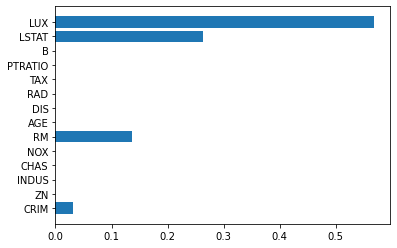

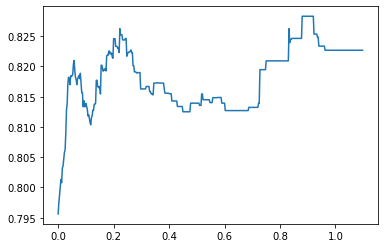

In [16]:
#В6 - ccp_alpha,
params = {'ccp_alpha':np.arange(0.0, 1.1, 0.0025),
          'random_state':[42]}
#тестирую модель
evaluating_the_model(metrics_cv, X, Y, scal = False, text = 'В6 - ccp_alpha', params = params)
#нарисуем зависимость точности модели от ccp_alpha
plt.plot(params['ccp_alpha'], metrics_cv['В6 - ccp_alpha']['test_score'])

In [17]:
#pprint(metrics_cv['В6 - ccp_alpha'])

В7 - коплекс параметров:  MSE 3.3196,  MAE 2.581,  R^2 0.8497


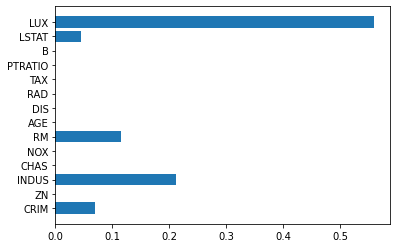

CPU times: user 13min 7s, sys: 4.82 s, total: 13min 12s
Wall time: 13min 15s


In [18]:
%%time
#В7 - коплекс параметров
params = {'ccp_alpha':np.arange(0.8, 0.96, 0.0025),
          'max_features':np.arange(8, len(X.columns) + 1, 1),
          'min_samples_leaf':np.arange(15, 25, 1),
          'max_depth':np.arange(4, 9, 1),
          'random_state':[42]}
#тестирую модель
evaluating_the_model(metrics, X, Y, scal = False, text = 'В7 - коплекс параметров', params = params)

In [19]:
pprint(metrics['В7 - коплекс параметров']['best'])

{'ccp_alpha': 0.8,
 'max_depth': 4,
 'max_features': 8,
 'min_samples_leaf': 19,
 'random_state': 42}


-------------------------------------------------------------------------------------------------------------------

In [33]:
#посмотрим коэффициент детерминации для нескольких полученых моделей
#В1 и В2 - без подбора параметров, В7 - несколько параметров сразу, 
#В3 - лучший вариант при подборе параметров по-отдельности
for key in metrics:
    print(f'{key}: R^2 = {metrics[key]["R^2"]}')
print(f'В3 - max_depth: R^2 = {metrics_cv["В3 - max_depth"]["R^2"]}')

В1 - "в лоб": R^2 = 0.8292
В2 - LUX: R^2 = 0.852
В7 - коплекс параметров: R^2 = 0.8497
В3 - max_depth: R^2 = 0.8847


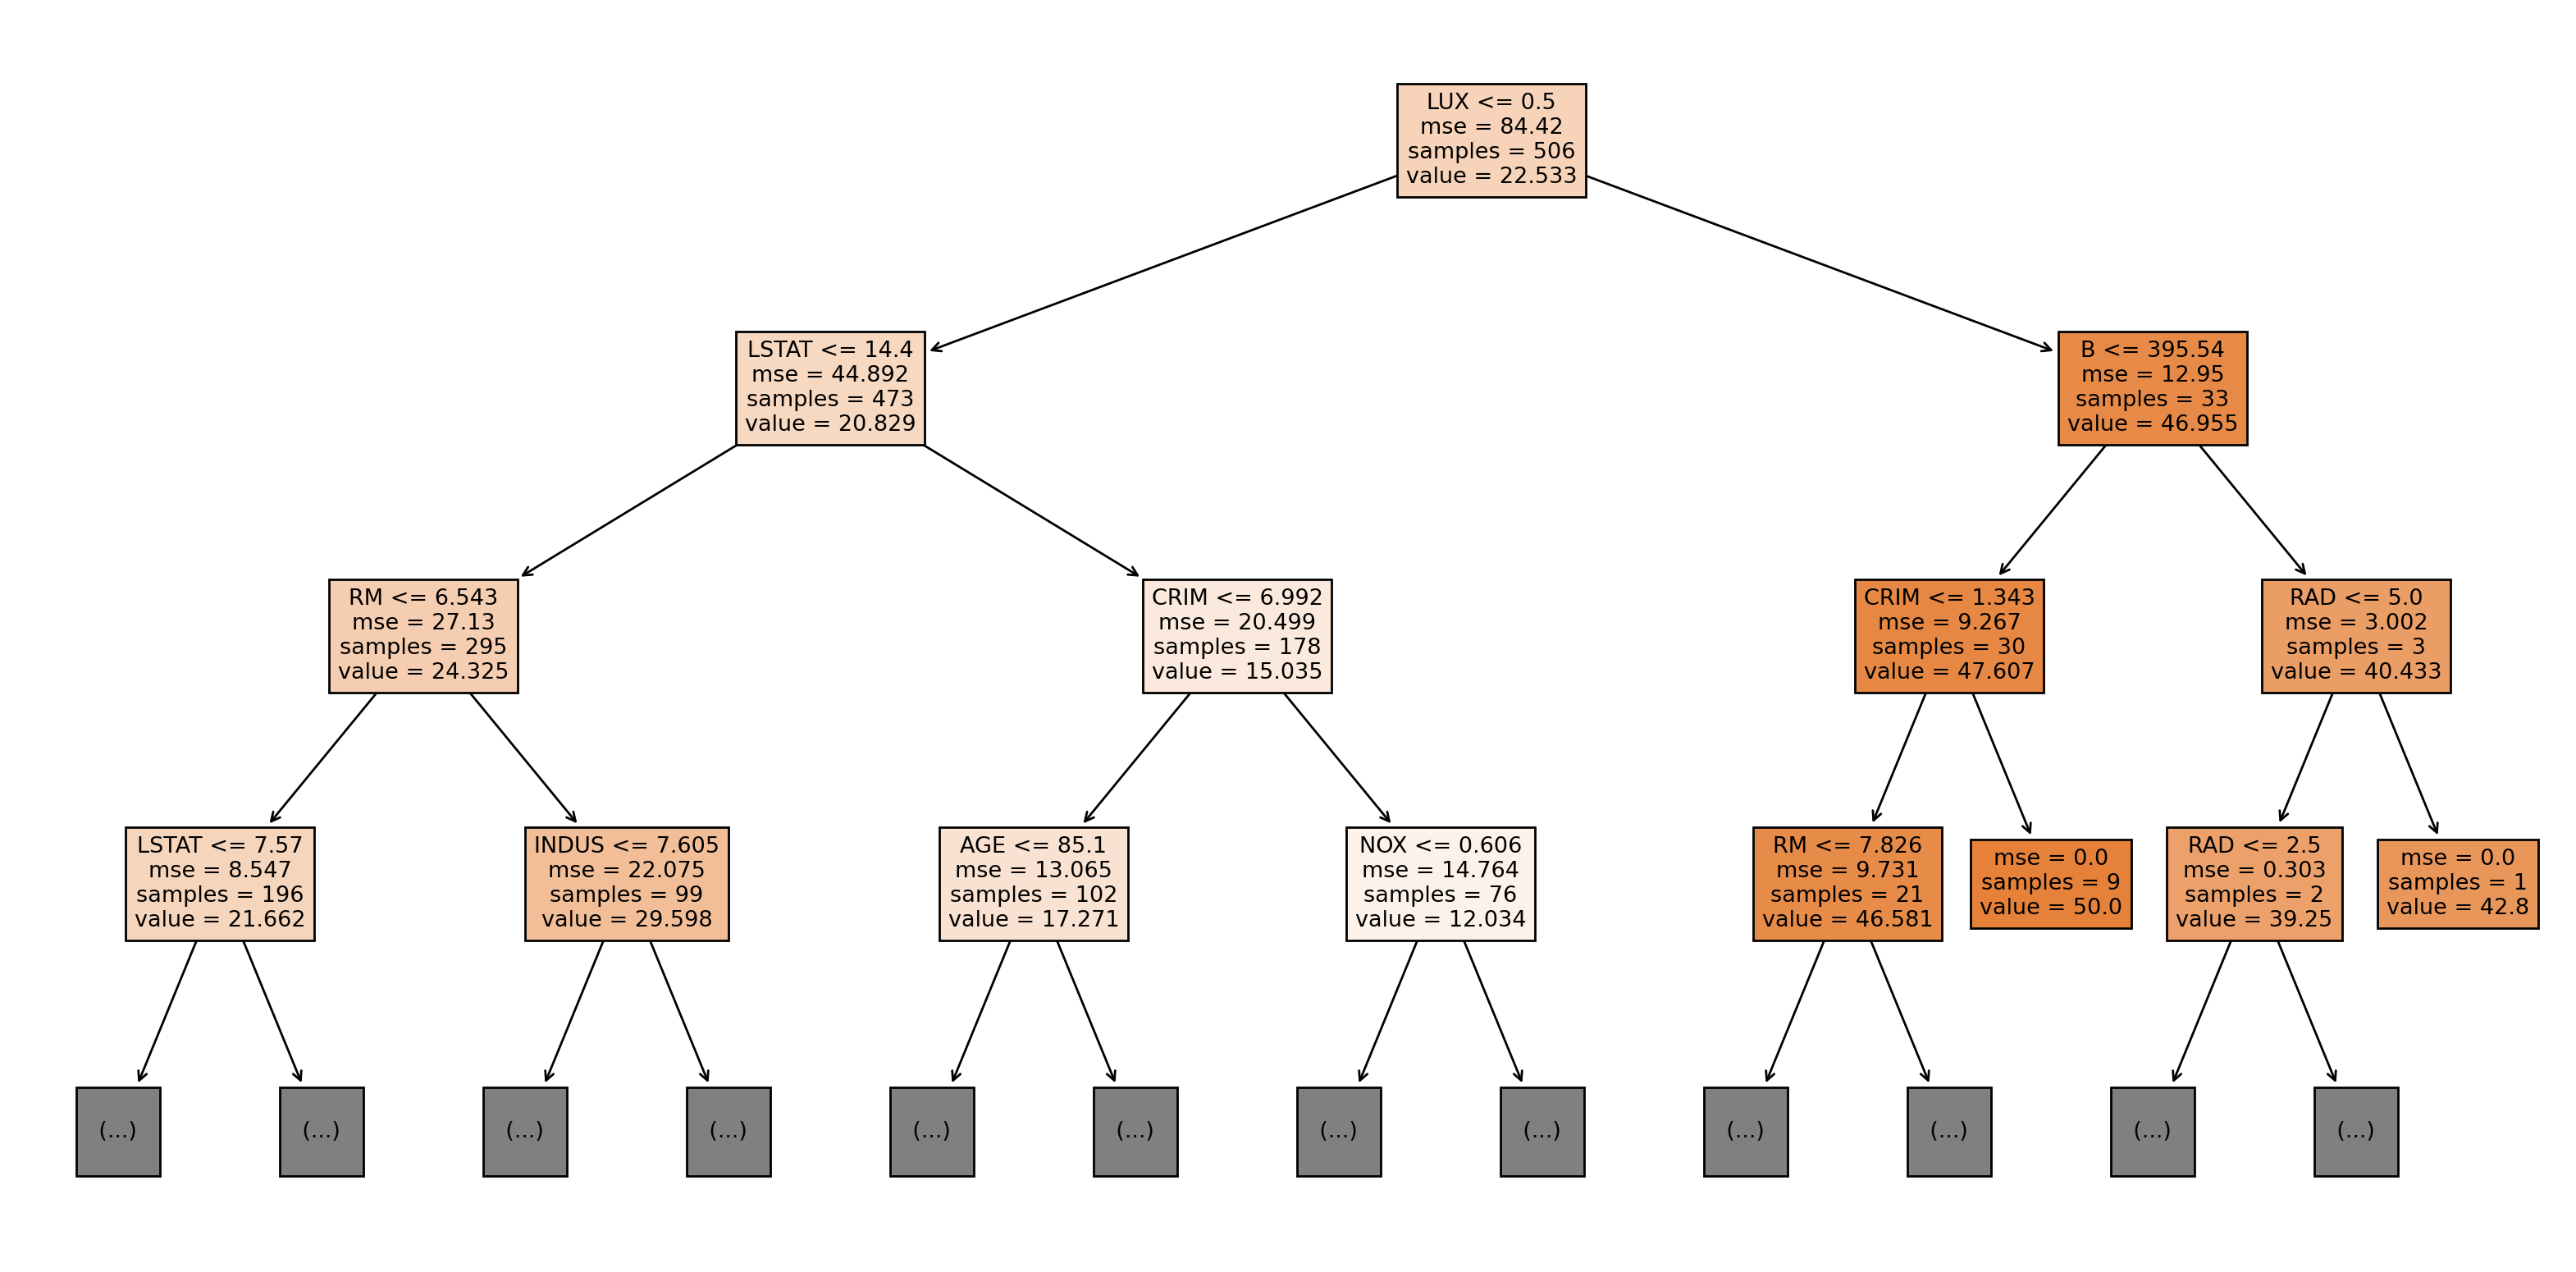

In [34]:
#для отрисовки дерева решений возьмем параметры лучшей модели - В3
clf = tree.DecisionTreeRegressor(max_depth = 6, random_state = 42)
clf = clf.fit(X, Y)
plt.figure(figsize=(20, 10), dpi = 200)
_ = tree.plot_tree(clf, filled = True, max_depth = 3, feature_names = X.columns)
plt.show()

In [22]:
#дерево решений не симметрично относительно корня, т.к. в корне анализируется признак LUX, справа 1, слева 0,
#сэмплов с LUX = 0 значительно больше

In [23]:
#Вывод:
# - для определения лучшей модели нужно пробовать разные варианты
# - методы, хорошо показавшие себя на, например, линейной модели (внесение переменной LUX для выделения клааса
#недвижимости) могут не принести желаемых результатов (R^2 меньше, чем даже для необработанных данных)
# - методы автоматизированного подбора гиперпараметров (в нашем случае GridSearchCV) также может показать результат
#не самый лучший (R^2 средний среди всех испробованных вариантов)
# - лучший результат дал метод ручного подбора гиперпараметров по-очереди (В3)

"""
Общий вывод:
нужен алгоритм подбора гиперпараметров, т.е. best practice, которого, к сожалению нет в лекции
"""